# Denoising Diffusion Probabilistic Models

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [2]:
# Define the DDPM model
class DDPM(nn.Module):
    def __init__(self, image_size, channels):
        super(DDPM, self).__init__()
        self.image_size = image_size
        self.channels = channels
        # Define a simple UNet-like architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Correct upsampling
            nn.ReLU(),
            nn.Conv2d(64, channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        assert decoded.shape == x.shape, f"Output shape {decoded.shape} does not match input shape {x.shape}"
        return decoded

In [3]:
# Define the forward diffusion process
def forward_diffusion(x, t, noise_schedule):
    noise = torch.randn_like(x)
    # Ensure alpha_t is broadcastable: shape [batch, 1, 1, 1]
    alpha_t = noise_schedule[t].view(-1, 1, 1, 1)
    return torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise, noise


In [4]:
# Hyperparameters
epochs = 10
batch_size = 64
learning_rate = 1e-4
image_size = 32
channels = 3

In [5]:
# Noise schedule
timesteps = 1000
beta = torch.linspace(1e-4, 0.02, timesteps)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

In [6]:
# Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR10(root="../datasets/cifar-10", train=True, download=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Model, optimizer, and loss function
model = DDPM(image_size, channels).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

In [8]:
# Training loop
for epoch in range(epochs):
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        t = torch.randint(0, timesteps, (images.size(0),), device=images.device)
        noisy_images, noise = forward_diffusion(images, t, alpha_hat)

        # Predict noise
        predicted_noise = model(noisy_images)
        loss = mse_loss(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

Epoch [1/10], Step [0/782], Loss: 0.9992
Epoch [1/10], Step [100/782], Loss: 0.4828
Epoch [1/10], Step [100/782], Loss: 0.4828
Epoch [1/10], Step [200/782], Loss: 0.2556
Epoch [1/10], Step [200/782], Loss: 0.2556
Epoch [1/10], Step [300/782], Loss: 0.2406
Epoch [1/10], Step [300/782], Loss: 0.2406
Epoch [1/10], Step [400/782], Loss: 0.2611
Epoch [1/10], Step [400/782], Loss: 0.2611
Epoch [1/10], Step [500/782], Loss: 0.2608
Epoch [1/10], Step [500/782], Loss: 0.2608
Epoch [1/10], Step [600/782], Loss: 0.2500
Epoch [1/10], Step [600/782], Loss: 0.2500
Epoch [1/10], Step [700/782], Loss: 0.2710
Epoch [1/10], Step [700/782], Loss: 0.2710
Epoch [2/10], Step [0/782], Loss: 0.2575
Epoch [2/10], Step [0/782], Loss: 0.2575
Epoch [2/10], Step [100/782], Loss: 0.2492
Epoch [2/10], Step [100/782], Loss: 0.2492
Epoch [2/10], Step [200/782], Loss: 0.2420
Epoch [2/10], Step [200/782], Loss: 0.2420
Epoch [2/10], Step [300/782], Loss: 0.2583
Epoch [2/10], Step [300/782], Loss: 0.2583
Epoch [2/10], Ste

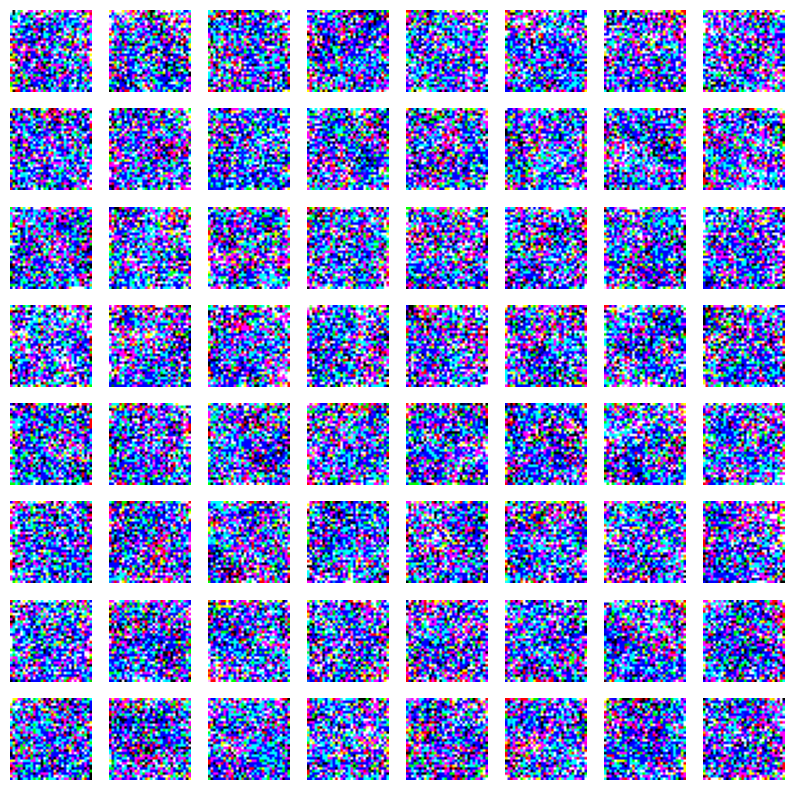

In [10]:
# Generate samples
with torch.no_grad():
    sample = torch.randn((batch_size, channels, image_size, image_size)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    for t in reversed(range(timesteps)):
        alpha_t = alpha[t].view(-1, 1, 1, 1)
        beta_t = beta[t].view(-1, 1, 1, 1)
        predicted_noise = model(sample)
        sample = (sample - beta_t * predicted_noise) / torch.sqrt(alpha_t)
        if t > 0:
            noise = torch.randn_like(sample)
            sample += noise * torch.sqrt(1 - alpha_t)
    sample = torch.clamp(sample, -1, 1) # Ensure pixel values are in the range [-1, 1]
    sample = (sample + 1) / 2  # Rescale to [0, 1]
    sample = sample.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to [batch, height, width, channels]
    # Visualize the generated samples
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(8, 8, i + 1)
        plt.imshow(sample[i])
        plt.axis('off')
    plt.show()